# **TP1**

In [1]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy
import matplotlib.pyplot as plt
import template_funciones as func
import template_funciones_2 as func2


# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [2]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

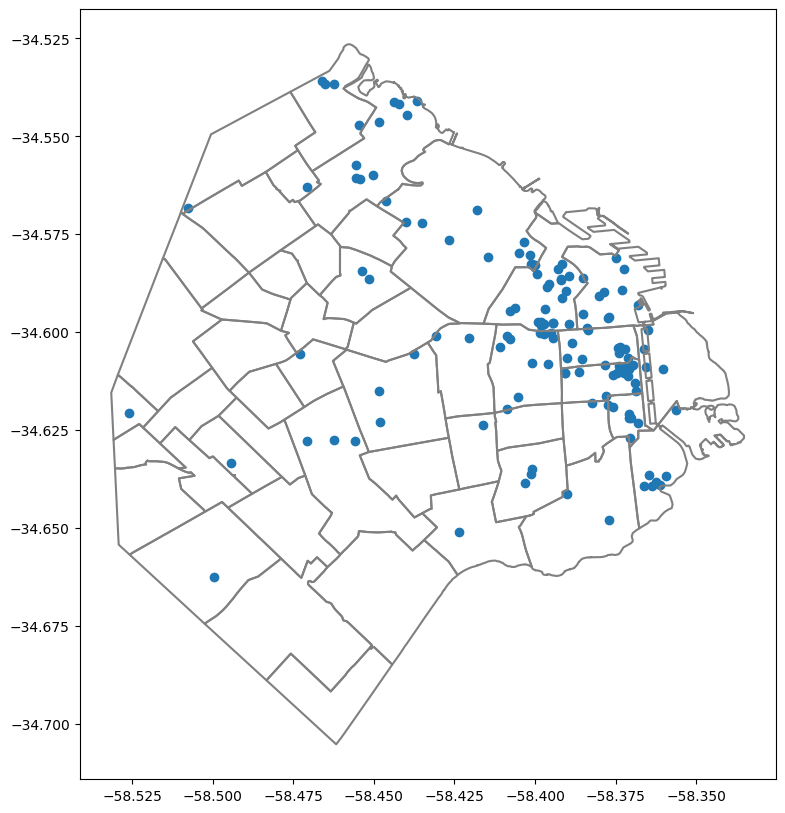

In [3]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184.

In [4]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa),
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [5]:
def construye_adyacencia(D,m):
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [6]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

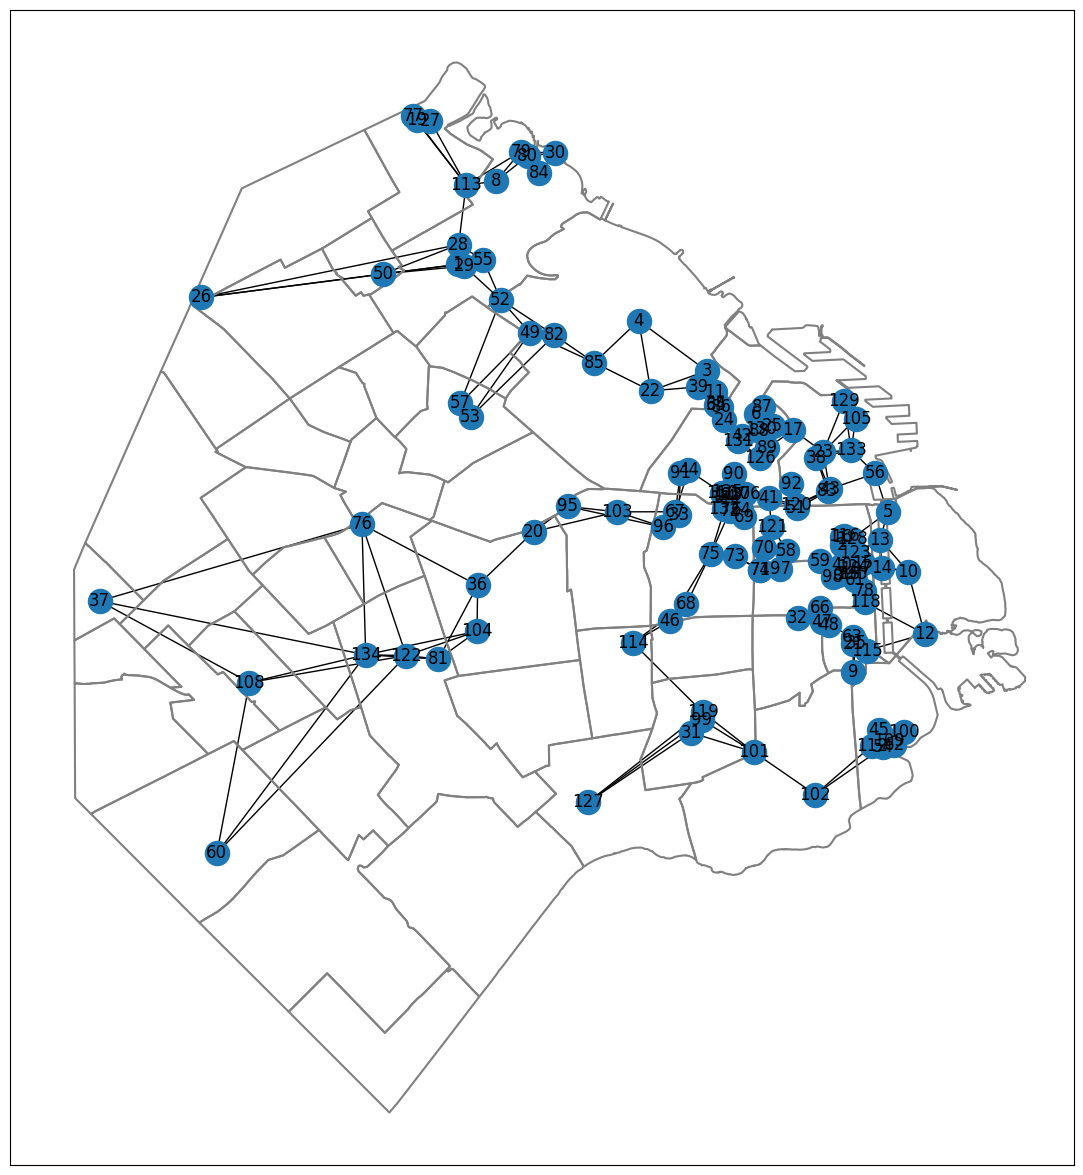

In [7]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1:
Debemos demostrar que el vector de rankings ***p*** es solución de la ecuación $M$ ***p*** = ***b*** donde

$$M = \frac{\it{N}}{α} (I - (1 - α) C ) \land  b = 1 $$

El objetivo entonces va a ser llegar a esta igualdad algebraicamente comenzando por la ecuación original de ***p***.

$$p = (1 - α) C p + \frac{α}{\it{N}} \space1$$

Comenzamos despejando ***1***

$$p - (1 - α) C p = \frac{α}{\it{N}}\space 1 $$

$$\frac{\it{N}}{α} p - \frac{\it{N}}{α}(1 - α) C p = 1$$

Sacamos factor común ***p***, en el proceso hacemos "aparecer" la matriz identidad en el primér término.

$$ (\frac{\it{N}}{α} I - \frac{\it{N}}{α}(1 - α) C ) p = 1$$

$$ \frac{\it{N}}{α} (I - (1 - α) C ) p = 1$$

Finalmente llegamos a la ecuación original,  $M$***p*** = ***1***

Queda demostrado que el vector ***p*** es solución de la ecuación


## Punto 2:

Debemos encontrar las condiciones para que exista una única solución a la ecuación $M p = b$

Esto ocurre únicamente si la matriz $M$ es inversible, que es el caso solo si $\frac{α}{\it{N}} (I - (1 - α) C )$ lo es.

Multiplicar una matriz por un escalar distinto de 0 no afecta su inversibilidad. Por lo tanto, basta saber que $\frac{\it{N}}{α}$ es mayor a 0 para obviar el termino.

Debemos entonces probar que $(I−(1−α)C)$, a la cual paso a llamar $g$, es inversible si $0<α<1$. Me fijo si es estríctamente diagonal dominante. Nos vamos a fijar si lo es por columnas. Queremos probar que:

$$ |g_{jj}| > \sum_{\substack{i = 1 \\ i \ne j}}^{n} |g_{ij}| $$

Veamos cuanto es la parte mayor de la desigualdad

$$ g_{jj} = I_{jj} - (1 - α) C_{jj} $$

Por definición de $C$ tiene ceros en sus diagonales, por lo que:

$$ g_{jj} = 1 - (1 - α) * 0 = 1 $$

Estudiemos la otra parte de la desigualdad.

$$ \sum_{\substack{i = 1 \\ i \ne j}}^{n} |g_{ij}| = \sum_{\substack{i = 1 \\ i \ne j}}^{n} | I_{ij} - (\alpha - 1) C_{ij}| $$

Por un lado la sumatoria de las columnas de la identidad sin el elemento de la diagonal es 0. Por otro sabemos que la matriz $C$ es estocástica por definición. Es decir, sus columnas suman 1. Como el único elemento que no estamos sumando es el 0 de la diagonal, el elemento $C_{ij}$ adentro de la sumatoria da 1. Por lo que queda:

$$ \sum_{\substack{i = 1 \\ i \ne j}}^{n} |g_{ij}| =  |1 - \alpha|$$

$$ 0 < \alpha < 1 \ ⇒ 0 < |1 - \alpha| < 1 \space \forall α \in (0, 1) $$

Finalmente probamos la desigualdad $|g_{jj}| > \sum_{\substack{i = 1 \\ i \ne j}}^{n} |g_{ij}|$. Queda demostrado que la matriz $M$ cumple las condiciones para que exista una única solución a la ecuación dada en el punto 1 pues tiene inversa para todo $0 < \alpha < 1$.

## Punto 3:

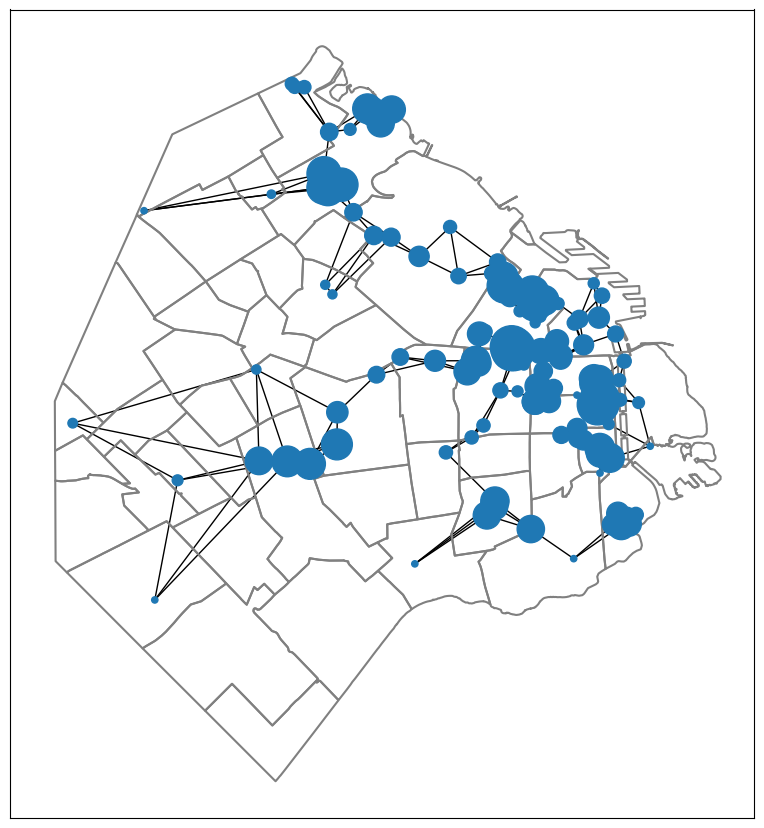

In [8]:

D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()
m = 3
alfa = 1/5
A = func.construye_adyacencia(D,m)
pr = func.calcula_pagerank(A,alfa)

np.set_printoptions(threshold=np.inf)

func.graficar_pagerank(pr,museos,barrios,0.7,A)

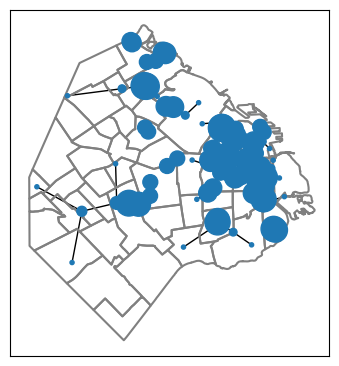

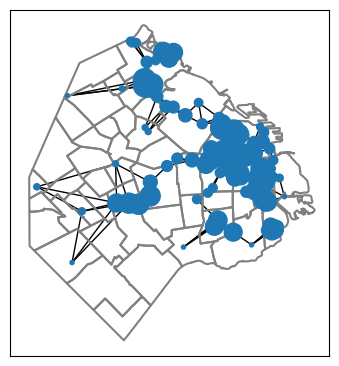

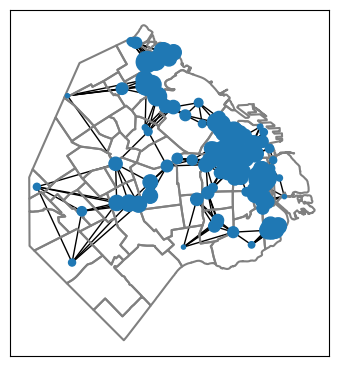

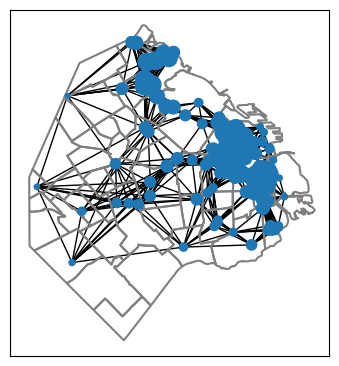

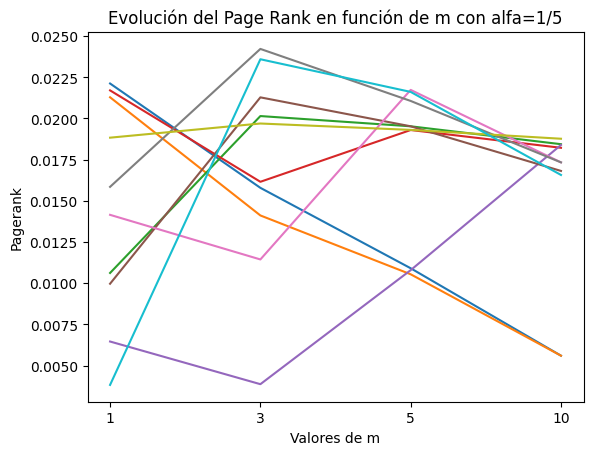

In [9]:
m_list = [1,3,5,10]

Nprincipales = 3 # Cantidad de principales
pr_list = [] # Lista para guardar scores

alfa = 1/5 # Valor de alfa para el Page Rank
for m in m_list:
    A = construye_adyacencia(D,m)
    pr = func.calcula_pagerank(A,alfa)
    pr_list.append(pr)
    func.graficar_pagerank(pr,museos,barrios,0.3,A)
plt.show() # purga configuracion

# guardamos los 3 principales nodos de cada una de las listas
principales = {}
for i, pr in enumerate(pr_list):
    principales[i] = np.argsort(pr)[-Nprincipales:]
# deduplicamos los nodos principales, para quedarnos con los únicos
principales = set([n for i in principales.values() for n in i])
# cada elemento de pr_principiantes es una lista con los pagerank del nodo correspondiente
pr_principales = []
for i, principal in enumerate(principales):
    pr_singular = []
    for j, pr in enumerate(pr_list):
        pr_singular.append(pr[principal])
    pr_principales.append(pr_singular)

x = np.arange(len(m_list)) # Valores de m

plt.xlabel('Valores de m')
plt.ylabel('Pagerank')
plt.title('Evolución del Page Rank en función de m con alfa=1/5')

plt.xticks(x, m_list)

for pr in pr_principales:
    y = np.array(pr_principales[0])
    plt.plot(x, pr) # Graficamos los scores de Page Rank de cada nodo principal

plt.show()

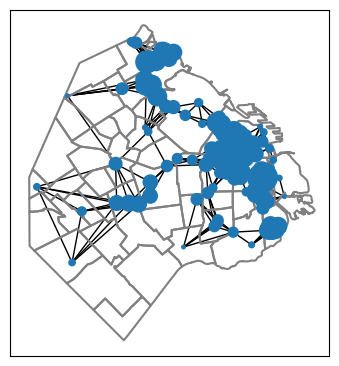

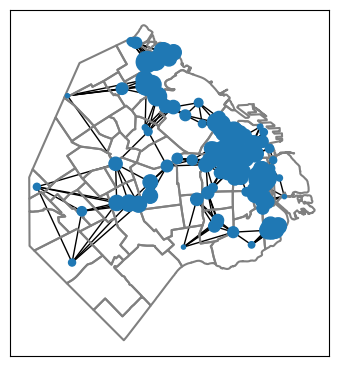

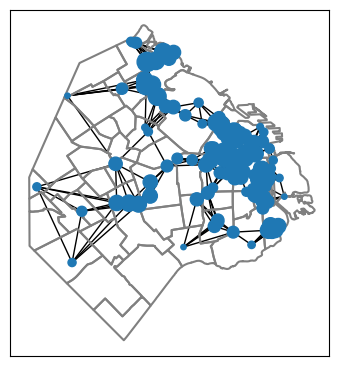

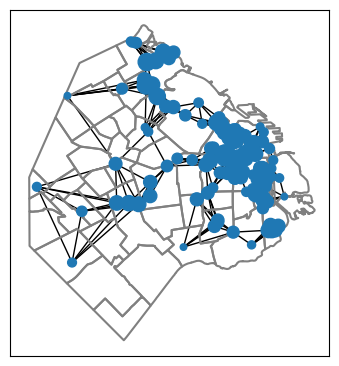

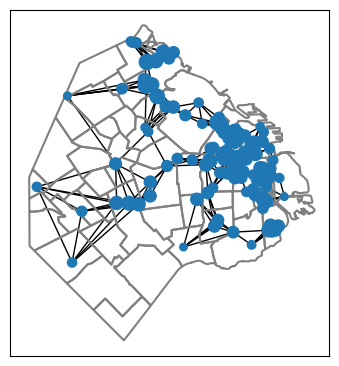

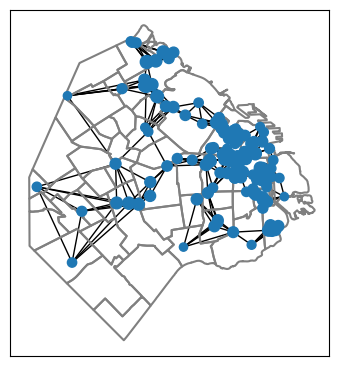

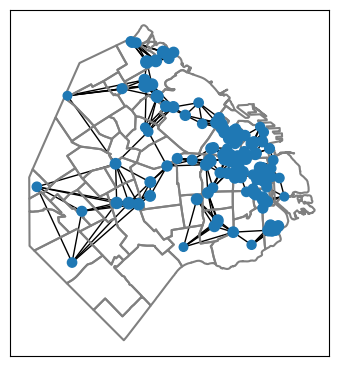

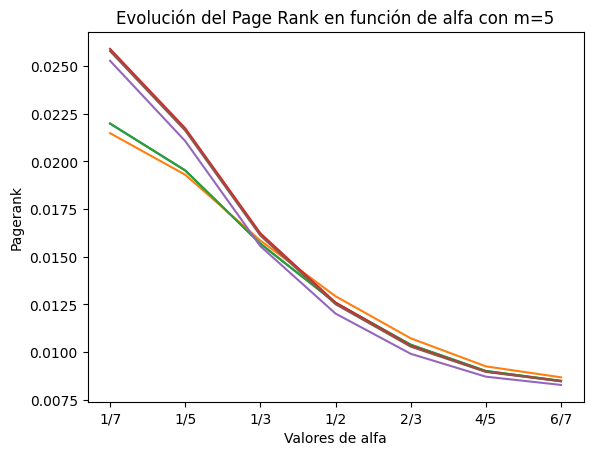

In [10]:
alfa_string = ['1/7','1/5','1/3','1/2','2/3','4/5','6/7'] # Para graficar los valores de alfa
alfa_list = [1/7,1/5,1/3,1/2,2/3,4/5,6/7]
pr_list = []

plt.rcdefaults()
m = 5
for alfa in alfa_list:
    A = construye_adyacencia(D,m)
    pr = func.calcula_pagerank(A,alfa)
    pr_list.append(pr) # Guardamos el score
    func.graficar_pagerank(pr,museos,barrios,0.3,A)

plt.show()

# guardamos los 3 principales nodos de cada una de las listas
principales = {}
for i, pr in enumerate(pr_list):
    principales[i] = np.argsort(pr)[-Nprincipales:] # Guardamos los 3 principales
# deduplicamos
principales = set([n for i in principales.values() for n in i])

pr_principales = []
for i, principal in enumerate(principales):
    pr_singular = []
    for j, pr in enumerate(pr_list):
        pr_singular.append(pr[principal])
    pr_principales.append(pr_singular)

x = np.arange(len(alfa_list))
plt.xlabel('Valores de alfa')
plt.ylabel('Pagerank')
plt.title('Evolución del Page Rank en función de alfa con m=5')
plt.xticks(x, alfa_list)
plt.xticks(x, alfa_string)

for pr in pr_principales:
    y = np.array(pr_principales[0])
    plt.plot(x, pr) # Graficamos los scores de Page Rank de cada nodo principal

plt.show()

$a)$

Cuando se cambia el valor de m, las posiciones no son para nada estables, tanto asi que hay 10 museos que ocupan el top 3 en al menos una de estas. Museos que en m=1 estaban en el maximo luego terminan bajo todo el resto en $m=10$.

Al variar el alfa, en cambio, se puede ver que las posiciones parecen no cambiar en orden de forma dramatica pero si hacerse mas claras de forma correspondiente a un valor mayor. Hay apenas 4 en cualquiera de los top 3. Aumenta la diferencia entre los museos de alto y bajo rango.

$b)$

Al aumentar alfa se concentra el ranking en ciertos museos de zonas de mayor concentracion, aquellos que tienen una mayor cantidad de conexiones entrantes. Con m parece tener el resultado opuesto, distribuyendo mas el pagerank hacia aquellos nodos alejados que si no quedarian aislados, con pocas o ninguna conexion entrante.

## Punto 4:
Tenemos que probar que $B^{-1} * w = v$  con $w$ siendo el vector que tiene en cada componente la cantidad de visitas que tuvo cada museo luego de $r$ pasos temporales y $v$ la cantidad de visitantes por museo al principio.

Partimos de:

$$ v = B^{-1} * w $$

$$v * B = w$$

Sabemos por definición que:

$$ B = \sum_{k = 0}^{r-1} C^k $$

Reemplazamos $B$ en la ecuación

$$ v * \sum_{k = 0}^{r-1} C^k = w$$

Como nos dice el tip que la distribución de visitantes en cada paso está dada por $C^k * v$. Como lo que queremos es encontrar la cantidad total de visitantes que pasan por un museo, podemos sumar todos esos vectores. Entonces tenemos:

$$ w = I * v + C * v + C^2 * v + ... + C^{r-1} * v = (I + C + C^2 + ... + C^{r-1}) * v $$

El primer término está dado por $v$ pues refiere a la posición inicial de los visitantes en cada museo. Finalmente queda:

$$ w = v* \sum_{k = 0}^{r-1} C^k $$

Que es la ecuación que queríamos probar, pues $B$ está definida como $B = \sum_{k = 0}^{r-1} C^k$ entonces:

$$w = v * B $$

Sabemos del punto 2 que B es inversible, por lo que:

$$ v = B^{-1} * w $$

Que es la ecuación a la que queríamos llegar.


## Punto 5:

In [11]:
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()
C = func.calcula_matriz_C_continua(D) # calculamos matriz en usando la ecuacion continua
r = 3
B = func.calcula_B(C, r)

w = np.loadtxt("visitas.txt")
v = func.calcula_x(B, w)
print("\nCantidad total de visitantes", func.norma1_matriz(v))


Cantidad total de visitantes 136605.0


c:\Users\Franc\Documents\Github\TP1_ALC_1C2025\template_funciones.py:122: RuntimeWarning: divide by zero encountered in divide
  F = 1/D


Generamos la matriz de transiciones y la procesamos para ver la cantidad de visitantes en cada museo tras 3 pasos. Luego calculamos la cantidad de visitantes total.

## Punto 6:
Para calcular la cota del error al estimar $v$ debemos usar la desigualdad de la consigna. Donde sabemos que:

$$ \frac{||v-\tilde{v}||_1}{||v||_{1}} = error \space relativo\space de\space v \space que\space queremos \space encontrar, $$

$$cond_{1}(B) = 5.051771176665003,  $$

$$\frac{||w-\tilde{w}||_1}{||w||_{1}} = 0.05 \space (por \space suposición) $$

Tenemos entonces que:

$$ \frac{||v-\tilde{v}||_1}{||v||_{1}} \leq 5.051771176665003 * 0.05 = 0.25258855883325015 $$

Que es finalmente el número que estábamos buscando.


In [12]:
cond_B = func.cond1(B)
print("\nNúmero de condición de B:", cond_B)


Número de condición de B: 5.051771176665007


# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, '1'),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 19

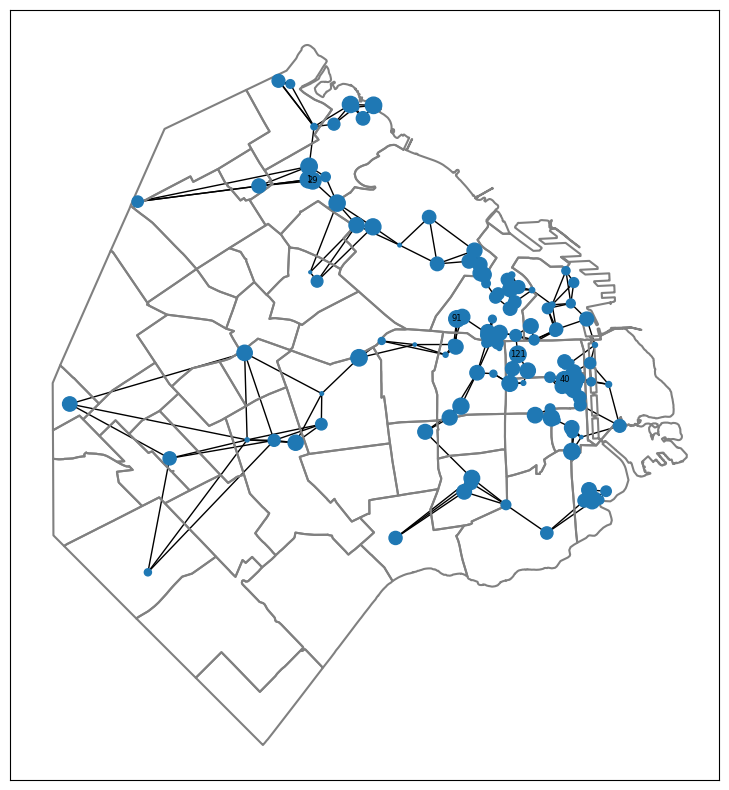

In [13]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres

#**TP2**

In [14]:
A_ejemplo = np.array([
    [0, 1, 1, 1, 0, 0, 0, 0],
    [1, 0, 1, 1, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 1, 0, 0],
    [1, 1, 1, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 1, 1, 1],
    [0, 0, 1, 0, 1, 0, 1, 1],
    [0, 0, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 1, 1, 1, 0]
])

#Punto 1

$a)$


Sea
$L = K - A$

Multiplicamos ambos lados por el vector de unos

$$ L * 1 = (K - A) * 1 = K * 1 - A * 1 $$

Multiplicar por el vector de 1s (a derecha) da el vector que tiene en la posición i, la sumatoria de la fila i.

Por lo que:

$$ A * 1 = K * 1 $$

Ya que $K_{ii} = \sum_{j = 1}^{N} A_{ij}$

Entonces, tenemos que

$$ L * 1 = K * 1 - K * 1 = 0 $$

Por lo tanto $1$ es autovector de $L$ con autovalor $\lambda = 0$.

Sea $R = A - P$

Multiplicamos ambos lados por el vector de unos

$$ R * 1 = (A - P) * 1 = A * 1 - P * 1 $$

Al igual que antes, multiplicar por el vector de unos de la sumatoria de cada fila.

$$ P*1 = \begin{bmatrix}
\sum_{j}^{} P_{1j}\\
\sum_{j}^{} P_{2j}\\
...\\
\sum_{j}^{} P_{Nj}\\
\end{bmatrix} $$

Podemos ver que

$$ \sum_{j}^{} P_{ij} = \sum_{j}^{} \frac{k_{i}k_{j}}{2E} = \frac{k_{i}}{2E} \sum_{j}{} k_{j} $$

Ya que $\sum_{j}^{} k_{j} = \sum_{i}^{} \sum_{j}^{} A_{ij} = 2E$, tenemos que

$$ \sum_{j}^{} P_{ij} = \frac{k_{i}}{2E} \sum_{j}{} k_{j} = \frac{k_{i}}{2E} 2E = k_{i} $$

Volviendo al principio, y por lo explicado en el caso $L$, nos queda

$$ R*1 = A * 1 - P * 1 = K*1 - K*1 = 0 $$

Y al igual que antes, $1$ es autovector de R, con autovalor $\lambda = 0$

El grupo que representa en la red es el trivial, donde cada grupo contiene a un solo nodo.

$b)$


Sea $v_{1}, v_{2}$ distintos, tal que

$$M*v_{1} = 𝜆_{1} * v_{1}$$

$$M*v_{2} = 𝜆_{2} * v_{2}$$

Multiplicamos por $v_{2}^{t}$ y $v_{1}^{t}$ respectivamente

$$v_{2}^{t}*M*v_{1} = 𝜆_{1} * v_{2}^{t} * v_{1}$$

$$v_{1}^{t}*M*v_{2} = 𝜆_{2} * v_{1}^{t} * v_{2}$$

Transpongo la primer ecuación, sabiendo que M es simétrica

$$ (v_{2}^{t} * M * v_{1})^{t} = (𝜆_{1} * v_{2}^{t} * v_{1})^{t} $$

$$ v_{1}^{t} * M * v_{2} = 𝜆_{1} * v_{1}^{t} * v_{2} $$

Juntando lo que obtuvimos con la segunda ecuación, nos queda

$$𝜆_{1} * v_{1}^{t} * v_{2} = 𝜆_{2} * v_{1}^{t}  * v_{2}$$

$$𝜆_{1} * v_{1}^{t} * v_{2} - 𝜆_{2} * v_{1}^{t}  * v_{2} = 0$$

$$(𝜆_{1} - 𝜆_{2}) * (v_{1}^{t} * v_{2}) = 0$$

Pero sabemos que los $\lambda$ son distintos, por lo que $v_{1}^{t} * v_{2}$ tiene que ser 0.

Ya que L y R son simétricas (se puede ver de forma evidente que sus transpuestas son iguales), se puede aplicar el mismo razonamiento con estas, y por lo tanto llegar a la misma conclusión.

$c)$


Sea $L * v = 𝜆 * v$

Por el punto a, sabemos que $L * 1 = 0$, y por lo tanto $\sum_{i}^{} L_{i} = 0$

Por lo que tenemos que

$$ L * v = 𝜆 * v $$
$$ \sum_{i}^{}(L * v) = \sum_{i}^{}(𝜆 * v) $$
$$ \sum_{i}^{} \sum_{j}^{} L_{ij} * v_{j} = 𝜆 * \sum_{i}^{}v_{i} $$

Ya que L es simétrica, $\sum_{i}^{} L_{ij} = \sum_{j}^{} L_{ij}$, y como $\sum_{i}^{} L_{i} = 0$

$$ \sum_{i}^{} \sum_{j}^{} L_{ij} * v_{j} = 𝜆 * \sum_{i}^{}v_{i} $$
$$ 0 = 𝜆 * \sum_{i}^{}v_{i} $$

Pero sabemos que $\lambda \neq 0 $, por lo que $\sum_{i}^{}v_{i} = 0$.

El razonamiento para R es exactamente el mismo, reemplazando $L$ por $R$.

#Punto 2

$a)$

Vi es autovector de $M$ con autovalor $λ_i$, es decir, $Mv_i = λv_i$.

Reemplazo $M$ por $M + μI$, y distribuyo $v_i$

$$ (M+μI)v_i ​$$
$$ Mv_i ​+ μIv_i $$

En base a Mvi = λvi, reemplazo Mvi

$$ Mv_i ​+ μIv_i ∧ Mv_i = λv_i $$
$$ λv_i ​+ μIv_i $$
$$ λv_i ​+ μv_i $$

Agrupo terminos
$$ (λ ​+ μ)vi $$

Resumiendo,
$$ (M + μI)vi = (λ ​+ μ)vi $$

Es decir, vi es autovector con autovalor λ ​+ μ.

Una matriz es inversible $<=>$ no tiene autovalores 0. Dado $μ + λ_i ≠ 0 ∀i$, es inversible.

$b)$

Sabemos que L es semidefinida positiva => autovalores son mayores o iguales a cero.
Aplicando el metodo del punto a, podemos ver que con un $μ > 0$, sus autovalores pasan a ser $λ ​+ μ$, mayores a $0$, es decir, es inversible.

El metodo de la potencia en una matriz converge en el autovector de mayor autovalor. Sabemos tambien que el menor autovalor de $L$ es $0$, por lo que el menor autovalor de $L + μI$ es $μ$, y que los autovalores de una matriz inversa son el inverso de la original
$(M^-1)v_i = (λ^-1)v_i$, pero los autovectores son los mismos. Entonces el mayor autovector de la inversa es de autovalor $1/μ$.


$c)$

Teniendo $Mv1$, reemplazo $M$ por $M − λ_1(​v_1 v_{1}^T) / (​v_{1}^T ​v_1)​$​, resultando

$$ [M −  λ_1(​v_1 v_1^T) / (​v_1^T ​v_1)]v_1 $$

Distribuyo terminos, y reemplazo $Mv1$ por
$λ1 v1$

$$Mv_1 − (λ_1 ​v_1 v_1^T v_1) / (​v_1^T ​v_1)$$
$$λ_1 v_1 − (λ_1 ​v_1 v_1^T v_1) / (​v_1^T ​v_1)$$

Finalmente, cancelo terminos iguales
$$λ_1 v_1 (v_1^T v_1) / (​v_1^T ​v_1) − λ_1 ​v_1$$
$$λ_1 v_1 − λ_1 ​v_1 = 0$$

El autovalor pasa a ser $0$, y al ser los autovectores ortogonales, los otros no se ven afectados.

#Punto 3

$a)$


In [15]:
L = func2.calcula_L(A_ejemplo)
R = func2.calcula_R(A_ejemplo)
print("Usando la matriz de ejemplo presentada en la figura 1 del enunciado.")
print("L = ", L)
print("R = ", R)

Usando la matriz de ejemplo presentada en la figura 1 del enunciado.
L =  [[ 3 -1 -1 -1  0  0  0  0]
 [-1  3 -1 -1  0  0  0  0]
 [-1 -1  4 -1  0 -1  0  0]
 [-1 -1 -1  4 -1  0  0  0]
 [ 0  0  0 -1  4 -1 -1 -1]
 [ 0  0 -1  0 -1  4 -1 -1]
 [ 0  0  0  0 -1 -1  3 -1]
 [ 0  0  0  0 -1 -1 -1  3]]
R =  [[-0.32142857  0.67857143  0.57142857  0.57142857 -0.42857143 -0.42857143
  -0.32142857 -0.32142857]
 [ 0.67857143 -0.32142857  0.57142857  0.57142857 -0.42857143 -0.42857143
  -0.32142857 -0.32142857]
 [ 0.57142857  0.57142857 -0.57142857  0.42857143 -0.57142857  0.42857143
  -0.42857143 -0.42857143]
 [ 0.57142857  0.57142857  0.42857143 -0.57142857  0.42857143 -0.57142857
  -0.42857143 -0.42857143]
 [-0.42857143 -0.42857143 -0.57142857  0.42857143 -0.57142857  0.42857143
   0.57142857  0.57142857]
 [-0.42857143 -0.42857143  0.42857143 -0.57142857  0.42857143 -0.57142857
   0.57142857  0.57142857]
 [-0.32142857 -0.32142857 -0.42857143 -0.42857143  0.57142857  0.57142857
  -0.32142857  0.6785714

In [16]:
v = np.random.uniform(-1, 1, L.shape[0])
v = v / np.linalg.norm(v)
Lambda = func2.calcula_lambda(L, v)
print("El lambda de L es ", Lambda)
Q = func2.calcula_Q(R, v)
print("El Q de R es ", Q)

El lambda de L es  8.0
El Q de R es  -1.2009599006321322e+16


$b)$


In [17]:
L = func2.calcula_L(A_ejemplo)
R = func2.calcula_R(A_ejemplo)

mu = 0.1
v_L, l_L, _ = func2.metpotI2(L, mu)
v_R, l_R, _ = func2.metpot1(R)

s_L = np.sign(v_L)
s_R = np.sign(v_R)

print("El autovector asociado al segundo autovalor más chico de la matriz L es ", v_L)
print("El autovector asociado al autovalor más grande de R es", v_R)

print("El vector s asociado a L es ",s_L)
print("El vector s asociado a R es ",s_R)

MaxRep alcanzado
El autovector asociado al segundo autovalor más chico de la matriz L es  [ 0.49439699  0.1801058   0.30060716  0.34512626 -0.22074312 -0.1684024
 -0.50549922 -0.42548838]
El autovector asociado al autovalor más grande de R es [ 0.39410264  0.39410264  0.30766112  0.30775128 -0.30775128 -0.30766112
 -0.39410264 -0.39410264]
El vector s asociado a L es  [ 1.  1.  1.  1. -1. -1. -1. -1.]
El vector s asociado a R es  [ 1.  1.  1.  1. -1. -1. -1. -1.]


Esto nos muestra que el algoritmo que trabaja con L, separa los nodos en los grupos G1={1,2,7,8} y G2={3,4,5,6}. Mientras que el que trabaja con R, nos da la distribución de grupos esperada, de la forma G1={1,2,3,4} y G2={5,6,7,8}.

La partición que uno esperaría de forma intuitiva sería la de los grupos {1,2,3,4} y {5,6,7,8}. En este caso, el vector s de R coincide perfectamente con esta partición, lo que podría demostrar una buena efectividad del método basado en modularidad. Esto se debe a que el método de modularidad permite detectar mejor las agrupaciones altamente densas, en términos de relaciones, en un grafo.

Por otro lado, la partición obtenida por del vector s asociado a L, no concuerda con los resultados esperados. Esta partición es facilmente influenciable por pequeñas variaciones, lo cual hace que los resultados sean variados (en especial con los nodos cercanos a la separación esperada).

$c)$


In [18]:
print("El grafo resultante del metodo laplaciano es: ", func2.laplaciano_iterativo(A_ejemplo,2))
print("El grafo resultante del metodo de modularidad es: ", func2.modularidad_iterativo(A_ejemplo))

El grafo resultante del metodo laplaciano es:  [[5, 6, 7], [4], [1], [0, 2, 3]]
El grafo resultante del metodo de modularidad es:  [[4, 5, 6, 7], [0, 1, 2, 3]]


Podemos ver que el metodo de modularidad produce un grafo cortado en los 2 grupos mas aparentes a la vista, G1={1,2,3,4} y G2={5,6,7,8}, mientras que el laplaciano los subdivide a ambos una vez mas, resultando en G1={1,4}, G2={2,3}, G3={5,6} y G4={7,8}.

#Punto 4

In [19]:
# Reload the module to ensure all functions are available
import importlib
importlib.reload(func2)
print("Module reloaded successfully")

Module reloaded successfully


El grafo resultante del metodo de modularidad con m = 1 tiene 1 grupo/s y es: [range(0, 136)]


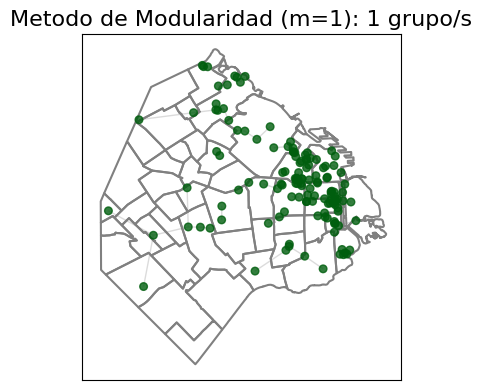

El grafo resultante del metodo de modularidad con m = 3 tiene 15 grupo/s y es: [[58, 70, 71, 73, 74, 121], [46, 51, 67, 68, 83, 91, 92, 114, 120], [7, 41, 44, 64, 69, 72, 75, 90, 93, 94, 106, 110, 111, 117, 125, 132], [2, 5, 16, 116, 128], [0, 10, 12, 13, 14, 15, 18, 40, 59, 61, 78, 98, 107, 118, 123, 124, 135], [6, 17, 25, 42, 87, 88, 89, 126, 130, 131], [23, 24, 34, 38, 43, 56, 65, 86, 105, 129, 133], [1, 26, 28, 29, 49, 50, 52, 53, 55, 57, 82, 85, 113], [8, 19, 27, 30, 77, 79, 80, 84], [9, 21, 32, 35, 47, 48, 63, 66, 115], [3, 4, 11, 22, 33, 39, 97], [45, 54, 62, 100, 102, 109, 112], [31, 99, 101, 119, 127], [95, 96, 103], [20, 36, 37, 60, 76, 81, 104, 108, 122, 134]]
 3 tiene 15 grupo/s y es: [[58, 70, 71, 73, 74, 121], [46, 51, 67, 68, 83, 91, 92, 114, 120], [7, 41, 44, 64, 69, 72, 75, 90, 93, 94, 106, 110, 111, 117, 125, 132], [2, 5, 16, 116, 128], [0, 10, 12, 13, 14, 15, 18, 40, 59, 61, 78, 98, 107, 118, 123, 124, 135], [6, 17, 25, 42, 87, 88, 89, 126, 130, 131], [23, 24, 34, 38

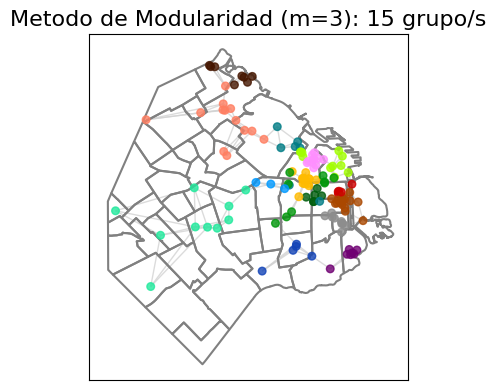

El grafo resultante del metodo de modularidad con m = 5 tiene 12 grupo/s y es: [[23, 38, 105, 133], [6, 17, 24, 25, 42, 87, 88, 89, 126, 129, 130, 131], [3, 11, 22, 34, 39, 43, 51, 58, 65, 71, 74, 83, 86, 92, 120], [31, 45, 54, 62, 99, 100, 101, 102, 109, 112, 114, 119, 127], [8, 19, 27, 28, 30, 55, 77, 79, 80, 84, 113], [36, 37, 60, 76, 81, 104, 108, 122, 134], [1, 4, 26, 29, 49, 50, 52, 53, 57, 82, 85], [20, 46, 68, 70, 73, 95, 96, 103, 121], [7, 33, 41, 44, 64, 67, 69, 72, 75, 90, 91, 93, 94, 106, 110, 111, 117, 125, 132], [56], [9, 12, 21, 32, 35, 47, 48, 63, 66, 97, 115], [0, 2, 5, 10, 13, 14, 15, 16, 18, 40, 59, 61, 78, 98, 107, 116, 118, 123, 124, 128, 135]]


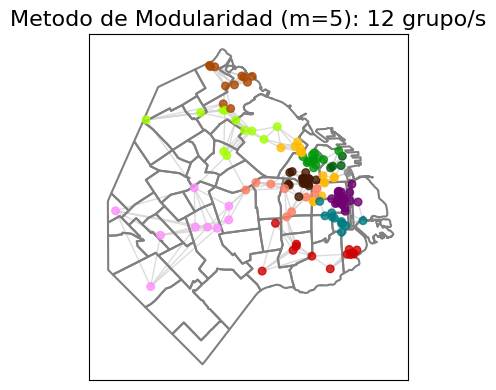

El grafo resultante del metodo de modularidad con m = 10 tiene 8 grupo/s y es: [[9, 12, 21, 32, 35, 45, 47, 48, 54, 62, 63, 66, 100, 101, 102, 109, 112, 115], [0, 2, 5, 10, 13, 14, 15, 16, 18, 40, 43, 56, 59, 61, 78, 83, 97, 98, 107, 116, 118, 123, 124, 128, 133, 135], [20, 31, 46, 58, 68, 71, 74, 99, 104, 114, 119, 127], [92], [7, 33, 41, 44, 51, 64, 67, 69, 70, 72, 73, 75, 90, 91, 93, 94, 95, 96, 103, 106, 110, 111, 117, 120, 121, 125, 132], [1, 8, 19, 26, 27, 28, 29, 30, 49, 50, 52, 53, 55, 57, 77, 79, 80, 82, 84, 113], [36, 37, 60, 76, 81, 108, 122, 134], [3, 4, 6, 11, 17, 22, 23, 24, 25, 34, 38, 39, 42, 65, 85, 86, 87, 88, 89, 105, 126, 129, 130, 131]]


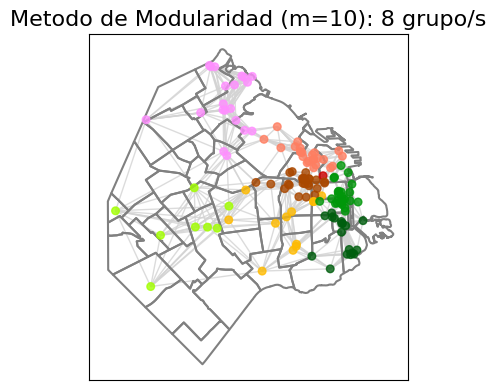

El grafo resultante del metodo de modularidad con m = 50 tiene 2 grupo/s y es: [[1, 3, 4, 6, 7, 8, 11, 17, 19, 20, 22, 24, 25, 26, 27, 28, 29, 30, 33, 34, 36, 37, 39, 42, 44, 49, 50, 52, 53, 55, 57, 60, 65, 67, 72, 76, 77, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 103, 104, 106, 108, 110, 111, 113, 117, 122, 125, 126, 129, 130, 131, 132, 134], [0, 2, 5, 9, 10, 12, 13, 14, 15, 16, 18, 21, 23, 31, 32, 35, 38, 40, 41, 43, 45, 46, 47, 48, 51, 54, 56, 58, 59, 61, 62, 63, 64, 66, 68, 69, 70, 71, 73, 74, 75, 78, 83, 92, 97, 98, 99, 100, 101, 102, 105, 107, 109, 112, 114, 115, 116, 118, 119, 120, 121, 123, 124, 127, 128, 133, 135]]


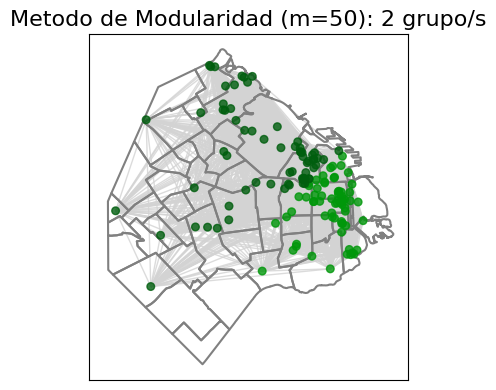

El grafo resultante del metodo laplaciano con m = 1 y 0 nivel/es tiene 1 grupo/s y es: [range(0, 136)]


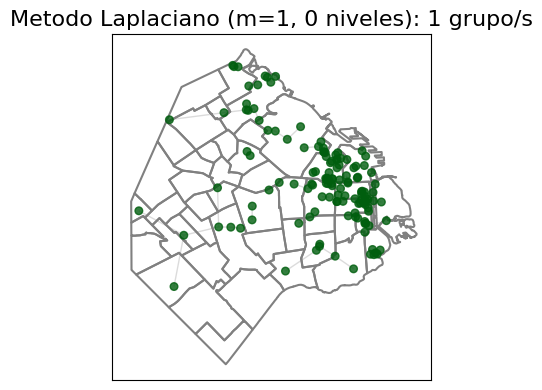

El grafo resultante del metodo laplaciano con m = 3 y 4 nivel/es tiene 16 grupo/s y es: [[49, 52, 53, 57, 82], [1, 26, 28, 29, 45, 50, 55, 62, 100, 109], [19, 27, 77, 113], [8, 30, 79, 80, 84], [4, 39], [3, 22, 85], [11, 24], [34, 65, 86], [9, 12, 21, 32, 35, 47, 48, 61, 63, 66, 78, 115, 118, 135], [0, 15, 18, 40, 59, 98, 107, 124], [6, 25, 42, 87, 88, 89, 126, 130, 131], [2, 5, 10, 13, 14, 16, 17, 23, 38, 41, 43, 51, 56, 58, 70, 83, 92, 105, 116, 120, 121, 123, 128, 129, 133], [7, 90, 93, 106, 117, 125], [46, 64, 68, 69, 71, 72, 73, 74, 75, 94, 97, 111, 132], [31, 36, 37, 54, 60, 76, 81, 99, 101, 102, 104, 108, 112, 114, 119, 122, 127, 134], [20, 33, 44, 67, 91, 95, 96, 103, 110]]


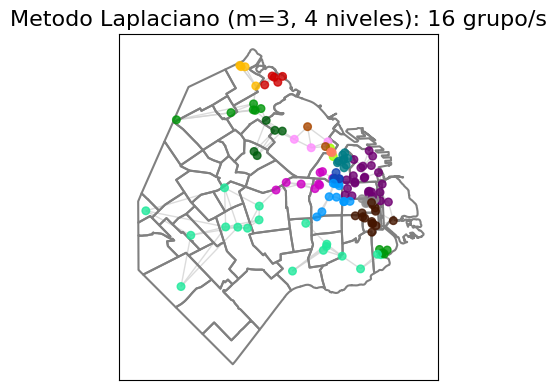

El grafo resultante del metodo laplaciano con m = 5 y 3 nivel/es tiene 8 grupo/s y es: [[2, 5, 13, 16, 59, 116, 123, 128], [14, 15, 18, 40, 61, 107, 124, 135], [10, 21, 35, 47, 66, 115, 118], [0, 9, 12, 48, 63, 78, 98], [3, 4, 6, 11, 17, 22, 23, 24, 25, 32, 34, 38, 39, 42, 43, 51, 56, 58, 65, 70, 71, 73, 74, 83, 85, 86, 87, 88, 89, 92, 97, 105, 120, 121, 126, 129, 130, 131, 133], [1, 8, 19, 20, 26, 27, 28, 29, 30, 31, 33, 36, 37, 44, 45, 46, 49, 50, 52, 53, 54, 55, 57, 60, 62, 67, 68, 75, 76, 77, 79, 80, 81, 82, 84, 91, 95, 96, 99, 100, 101, 102, 103, 104, 108, 109, 112, 113, 114, 119, 122, 127, 134], [7, 72, 90, 94, 106, 110, 111, 132], [41, 64, 69, 93, 117, 125]]


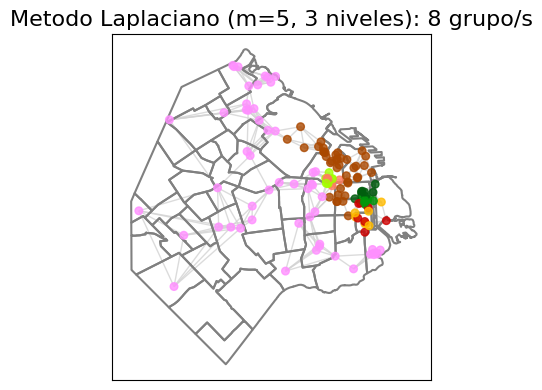

El grafo resultante del metodo laplaciano con m = 10 y 3 nivel/es tiene 8 grupo/s y es: [[2, 5, 10, 13, 14, 15, 16, 56, 116, 123, 128], [0, 18, 40, 59, 98, 107, 124, 135], [12, 35, 47, 48, 61, 63, 66, 78, 118], [9, 21, 45, 54, 62, 100, 109, 112, 115], [3, 4, 6, 11, 17, 22, 23, 24, 25, 34, 38, 39, 42, 43, 65, 83, 85, 86, 87, 88, 89, 92, 105, 126, 129, 130, 131, 133], [1, 8, 19, 20, 26, 27, 28, 29, 30, 36, 37, 49, 50, 52, 53, 55, 57, 60, 76, 77, 79, 80, 81, 82, 84, 95, 101, 102, 104, 108, 113, 114, 122, 127, 134], [31, 32, 41, 46, 51, 58, 64, 68, 69, 70, 71, 72, 73, 74, 75, 97, 99, 119, 120, 121], [7, 33, 44, 67, 90, 91, 93, 94, 96, 103, 106, 110, 111, 117, 125, 132]]


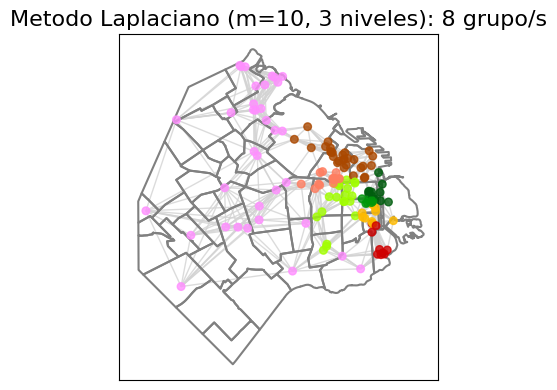

El grafo resultante del metodo laplaciano con m = 50 y 1 nivel/es tiene 2 grupo/s y es: [[0, 2, 5, 9, 10, 12, 13, 14, 15, 16, 18, 21, 23, 31, 32, 35, 38, 40, 41, 43, 45, 46, 47, 48, 51, 54, 56, 58, 59, 61, 62, 63, 64, 66, 68, 69, 70, 71, 73, 74, 75, 78, 83, 92, 97, 98, 99, 100, 101, 102, 105, 107, 109, 112, 114, 115, 116, 118, 119, 120, 121, 123, 124, 127, 128, 133, 135], [1, 3, 4, 6, 7, 8, 11, 17, 19, 20, 22, 24, 25, 26, 27, 28, 29, 30, 33, 34, 36, 37, 39, 42, 44, 49, 50, 52, 53, 55, 57, 60, 65, 67, 72, 76, 77, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 103, 104, 106, 108, 110, 111, 113, 117, 122, 125, 126, 129, 130, 131, 132, 134]]


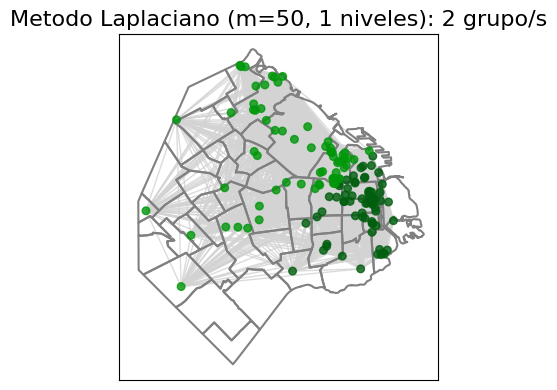

In [20]:
def simetriza_matriz(A):
  # A′ = ⌈ (1/2) (A + At)⌉
  return np.ceil((1/2) * (A + A.T))

m_list = [1,3,5,10,50]

for m in m_list:
    plt.rcdefaults()
    
    A = construye_adyacencia(D,m)
    A = simetriza_matriz(A)
    mod_A = func2.modularidad_iterativo(A)
    size = len(mod_A)
    print("El grafo resultante del metodo de modularidad con m =",m,"tiene",size,"grupo/s y es:",mod_A)
    
    # Visualizar clusters de modularidad
    func2.graficar_grupos(museos, barrios, 0.3, A, mod_A, 
                     titulo=f"Metodo de Modularidad (m={m}): {size} grupo/s")
    plt.show()

    

nivel_list = [0,4,3,3,1] # Lista de niveles precalculados
for m in m_list:
    plt.rcdefaults()
    
    A = construye_adyacencia(D,m)
    A = simetriza_matriz(A)
    niveles = nivel_list[m_list.index(m)]
    lap_A = func2.laplaciano_iterativo(A,niveles)
    size = len(lap_A)
    print("El grafo resultante del metodo laplaciano con m =",m,"y",niveles,"nivel/es tiene",size,"grupo/s y es:",lap_A)
    
    # Visualizar clusters laplacianos
    func2.graficar_grupos(museos, barrios, 0.3, A, lap_A, 
                     titulo=f"Metodo Laplaciano (m={m}, {niveles} niveles): {size} grupo/s")
    plt.show()

Valores bajos mayores a $1$ de $m$ parecen resultar en la mayor cantidad de grupos, y por lo tanto divisiones, con el metodo de modularidad. $m=1$ resulta en un solo grupo.

El numero de niveles me permite controlar directamente la cantidad de grupos, pero no su distribucion, asi que, centrandome en asemejar esta magnitud, la cantidad de niveles varia dependiendo m, con $0$ para $m=1$, $4$ para $m=3$, $3$ para $m=5$, $3$ para $m=10$, y $1$ para $m=50$. Si bien la cantidad de grupos en el metodo de modularidad varia, suele rondar los mismos valores. Parecen resultar en agrupaciones similares.

#Punto 5

A lo largo del TP1, vimos como, partiendo de una serie de museos representados por una posicion, podiamos generar grafos en base a matrizes de adyacencia, tanto con un numero limitado de conexiones a los nodos mas cercanos como en forma de un grafo pesado con conexiones inversamente proporcionales a la distancia. Adicionalmente, implementamos un algoritmo de Page Rank, que nos indico cuales serian los museos mas concurridos en los grafos, y analisamos como, al variar el *factor de amortiguamiento*,se veian afectados los resultados. Concluimos que, a medida que este valor aumentaba, se iban concentrando los valores resultantes, pero el efecto en el orden era minimo.

Vimos tambien que, al generar los grafos de conexiones limitadas, el numero de conexiones tenia un efecto significativo sobre el calculo de flujo. Los grafos mas conexos resultaban en distribuciones de pagerank mas proximas entre si, con menor diferencia entre museos, y ademas tenia un gran efecto en el orden final.

En el TP2, aplicamos distintos metodos de division de grafos, especificamente el metodo *laplaciano* y el metodo de *modularidad*. Observamos que el método laplaciano puede producir particiones poco intuitivas, y requiere mayor conocimiento por parte del usuario a la hora de ser usado, ya que no toma decisiones propias sobre la cantidad de grupos resultantes. En cambio, el método de modularidad tiende a encontrar divisiones más esperables, y decide automáticamente detener la partición cuando continuar resultaria en un grafo de igual o menor modularidad. Por otro lado, esto significa que no tenemos control sobre el grafo resultante dado un input.

Al aplicar estas estrategias sobre los grafos de museos, lo anteriormente descripto se vio reflejado. Examinamos como la variacion de *m* afectaba a los resultados de algoritmos de division de grafos. Si bien el metodo laplaciano no toma decisiones sobre el numero de grupos, el metodo de modularidad mostro ser afectado por este, con menores valores resultando en una mayor cantidad, a excepcion del grafo con $m=1$, en cuyo caso el grafo se mantuvo sin cambios. Ajustamos la cantidad de niveles del metodo laplaciano para asemejar los grafos resultantes, pero si bien se acerco en numero de grupos y distribuciones, nada asegura que las particiones sean equivalentes.

En sintesis, los trabajos practicos nos permitieron analizar como distintos metodos para construir conexiones pueden afectar procesos posteriores, ya sea de modificacion o de analisis, aun con la misma informacion inicial, y como diferentes metodos con el mismo proposito pueden tener resultados muy distintos.
